# **Implementing Thompson Sampling with Bayesian Logistic Regression for the Contextual Multi-Armed Bandit Problem**
This notebook implements the Thompson Sampling algorithm combined with Bayesian Regularized Logistic Regression for the Contextual Multi-Armed Bandit Problem, following the paper "[An Empirical Evaluation of Thompson Sampling](https://papers.nips.cc/paper/4321-an-empirical-evaluation-of-thompson-sampling.pdf)" by Chapelle et al.

In [ ]:
# Importing Necessary Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.optimize import minimize

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Contextual Bandit Environment
The following implementation creates a contextual multi-armed bandit environment. Each bandit is modelled with a logistic regression function defined by fixed ground truth weights.

In [ ]:
class ContextualBanditEnvironment:
    """
    A class representing a contextual multi-armed bandit environment.

    Attributes:
        n_bandits (int): Number of bandits.
        weights (dict): A dictionary of weights for each bandit.
    """
    def __init__(self, n_bandits):
        """
        Initialize the environment with a specified number of bandits.

        Args:
            n_bandits (int): Number of bandits.
        """
        self.n_bandits = n_bandits
        self.weights = {                      # the ground truth model for each bandit
            0: np.array([1.0, 0.4, 1.2]),
            1: np.array([0.5, 0.7, 0.5])
            }

    def draw(self, k, x1, x2):
        """
        Simulates a draw from the specified bandit given the context.

        Args:
            k (int): Index of the chosen bandit.
            x1 (float): First context value. (e.g., user's location)
            x2 (float): Second context value. (e.g., holiday destination)

        Returns:
            tuple: A tuple containing the reward (0 or 1), the regret, and the probability.
        """
        probabilities = {}

        for bandit, weight in self.weights.items():
            f_x = weight[0] + weight[1] * x1 + weight[2] * x2
            probability = 1 / (1 + np.exp(-f_x))  # Logistic function
            probabilities[bandit] = probability

        reward = np.random.choice([0, 1], p=[1 - probabilities[k], probabilities[k]])
        regret = max(probabilities.values()) - probabilities[k]

        return reward, regret, probabilities[k]

In [ ]:
bandit_env = ContextualBanditEnvironment(n_bandits=2)
print("true model weights for bandit 0:",bandit_env.weights[0])
print("true model weights for bandit 1:",bandit_env.weights[1])

true model weights for bandit 0: [1.  0.4 1.2]
true model weights for bandit 1: [0.5 0.7 0.5]


**Note:**

Inititally, the number of bandits were set to be a variable inputed by the user using random weights:

However, I found that initializing the ground truth model with random weights often resulted in poor differentiation between the optimal and suboptimal bandits causing the Logistic regression model to take much longer converge/ minimize the cumulative regret over time.

So in this version, the weights have been hardcoded to enforce differentiation between a fixed 2 bandits .








## Algorithm 3: Regularized Logistic Regression with Batch Updates

In [ ]:
class BayesianLogisticRegression:
    """
    Regularized Bayesian Logistic Regression with Gaussian priors.

    Attributes:
        lambda_ (float): Regularization parameter.
        alpha (float): Hyperparameter for posterior sampling.
        n_features (int): Number of features (includes bias).
        m (np.array): Mean of the weights' posterior distribution.
        q (np.array): Precision of the weights' posterior distribution.
        w (np.array): Current sample of weights.
    """
    def __init__(self, lambda_, alpha, n_features):
        self.lambda_ = lambda_
        self.alpha = alpha
        self.n_features = n_features + 1  # Add one feature for the bias
        self.m = np.zeros(self.n_features)
        self.q = np.ones(self.n_features) * lambda_
        self.w = self._sample_weights()

    def _loss(self, weights, X, y):
        regularization = 0.5 * (self.q * (weights - self.m)).dot(weights - self.m)
        log_likelihood = np.sum([np.log(1 + np.exp(-y[j] * weights.dot(X[j]))) for j in range(y.shape[0])])
        return regularization + log_likelihood

    def _gradient(self, weights, X, y):
        return self.q * (weights - self.m) + (-1) * np.array([
            y[j] * X[j] / (1.0 + np.exp(y[j] * weights.dot(X[j])))
            for j in range(y.shape[0])
        ]).sum(axis=0)

    def _sample_weights(self):
        """
        Sample weights from the posterior distribution.
        """
        return np.random.normal(self.m, self.alpha * (self.q) ** (-0.5), size=self.n_features)



    def fit(self, X, y, learning_rate=0.05, epochs=100, batch_size=64, log_variance=False):
            """
            Fit the model using stochastic gradient descent with improved stability.
            """
            X = np.hstack([np.ones((X.shape[0], 1)), X])  # Add bias column
            n_samples = X.shape[0]

            variance_history = [] if log_variance else None # tracking variance evolution

            for epoch in range(epochs):
                # Shuffle data
                indices = np.arange(n_samples)
                np.random.shuffle(indices)
                X, y = X[indices], y[indices]

                for start in range(0, n_samples, batch_size):
                    end = start + batch_size
                    X_batch, y_batch = X[start:end], y[start:end]

                    # Compute gradient
                    logits = X_batch.dot(self.w)
                    probabilities = (1 + np.exp(-logits)) ** (-1)
                    gradient = self.q * (self.w - self.m) + X_batch.T.dot(probabilities - y_batch)

                    # Update weights
                    self.w -= learning_rate * gradient

                # Update posterior parameters for Laplace approximation
                logits = X.dot(self.w)
                probabilities = (1 + np.exp(-logits)) ** (-1)
                self.q += (probabilities * (1 - probabilities)).dot(X ** 2)
                self.m = self.w

                # Log variance after each epoch
                if log_variance:
                    variance = (self.q) ** (-1)
                    variance_history.append(variance)

            return variance_history


    def predict_proba(self, X):
        """
        Predict probabilities using sampled weights.

        Args:
            X (np.array): Feature matrix.

        Returns:
            np.array: Predicted probabilities.
        """
        X = np.hstack([np.ones((X.shape[0], 1)), X])  # Add bias column
        self.w = self._sample_weights()
        logits = X.dot(self.w)
        probabilities = (1 + np.exp(-logits)) ** (-1)
        return np.array([1 - probabilities, probabilities]).T

### **Testing Implementation of Algorithm 3 Regularized Logistic Regression**

In [ ]:
bandit_env = ContextualBanditEnvironment(n_bandits=2)

# Generate synthetic data with 2 features
X = np.random.uniform(-6, 6, (15, 2))  # 15 samples, 2 features
y = np.array([bandit_env.draw(0, x[0], x[1])[0] for x in X])  # Generate true rewards from bandit 0


Bayes_LR = BayesianLogisticRegression(lambda_=0.5, alpha=1.0, n_features=2)
Bayes_LR.fit(X, y)

print("Posterior Mean Weights (m):", Bayes_LR.m)

# Predict probabilities for new data
X_new = np.array([[1.0, -2.0]])  # One new sample with 2 features
predicted_probs = Bayes_LR.predict_proba(X_new)


print("Predicted Probabilities:", predicted_probs)
print("\nBandit 0 Weights (Ground Truth):", bandit_env.weights[0])

_, _, true_prob = bandit_env.draw(0, X_new[0, 0], X_new[0, 1])
print("True Probabilities (Bandit 0):", [true_prob, 1 - true_prob])

Posterior Mean Weights (m): [2.2208562  0.65197281 2.73031719]
Predicted Probabilities: [[0.93138388 0.06861612]]

Bandit 0 Weights (Ground Truth): [1.  0.4 1.2]
True Probabilities (Bandit 0): [0.2689414213699951, 0.7310585786300049]


#### **Remarks**:

Weight Output:

* The printed weights indicate that the model learned a set of parameters, with the first value corresponding to the bias term and the remaining values corresponding to the two input features.

Implementation:
* Initially, I implemented the optimizer as described in the paper, using the methods: _loss, _gradient and the scipy.optimize.minimize for explicit minimization.

* However, I found this made training incredibly slow. So instead i'm using Stochastic Gradient Descent with mini batch updates.



## Algorithm 1: Thompson Sampling

In [ ]:
class ThompsonSamplingPolicy:
    """
    Thompson Sampling Policy using Bayesian Logistic Regression.

    Attributes:
        lambda_ (float): Regularization parameter.
        alpha (float): Hyperparameter for posterior sampling.
        n_bandits (int): Number of bandits.
        buffer_size (int): Maximum buffer size for past interactions.
    """
    def __init__(self, lambda_, alpha, n_bandits, buffer_size=200):
        self.lambda_ = lambda_
        self.alpha = alpha
        self.n_bandits = n_bandits
        self.buffer_size = buffer_size


    def _fit_predict(self, bandit_data, context):
        """
        Fit the model and predict probabilities for a given bandit's data.
        """
        model = BayesianLogisticRegression(self.lambda_, self.alpha, 2)  # Two features (x1, x2)
        variance_history = model.fit(bandit_data[['x1', 'x2']].values, bandit_data['reward'].values, # X, y
                                    log_variance=True)  # Track variance

        # Predict probability for the current context
        probabilities = model.predict_proba(np.array([context]))[0][1]
        return pd.DataFrame({'prob': [probabilities],
                            'm': [model.m],
                            'q': [model.q],
                            'variance_history': [variance_history]})


    def choose_bandit(self, interaction_data, context):
        """
        Choose the best bandit based on current interaction data.

        Args:
            interaction_data (pd.DataFrame): Data of past interactions.
            context (tuple): Current contextual features (x1, x2).

        Returns:
            int: Index of the chosen bandit.
        """
        interaction_data = interaction_data.tail(self.buffer_size)

        if interaction_data.groupby(['k', 'reward']).size().shape[0] == 4:

            ts_model_df = (interaction_data
                           .groupby('k')
                           .apply(self._fit_predict, context=context)
                           .reset_index().drop('level_1', axis=1).set_index('k'))

            best_bandit = int(ts_model_df['prob'].idxmax())
        else:
            best_bandit = np.random.choice(range(self.n_bandits))

        return best_bandit


## Testing and Validation

Simulation 1: 100%|██████████| 4000/4000 [05:03<00:00, 13.19it/s]


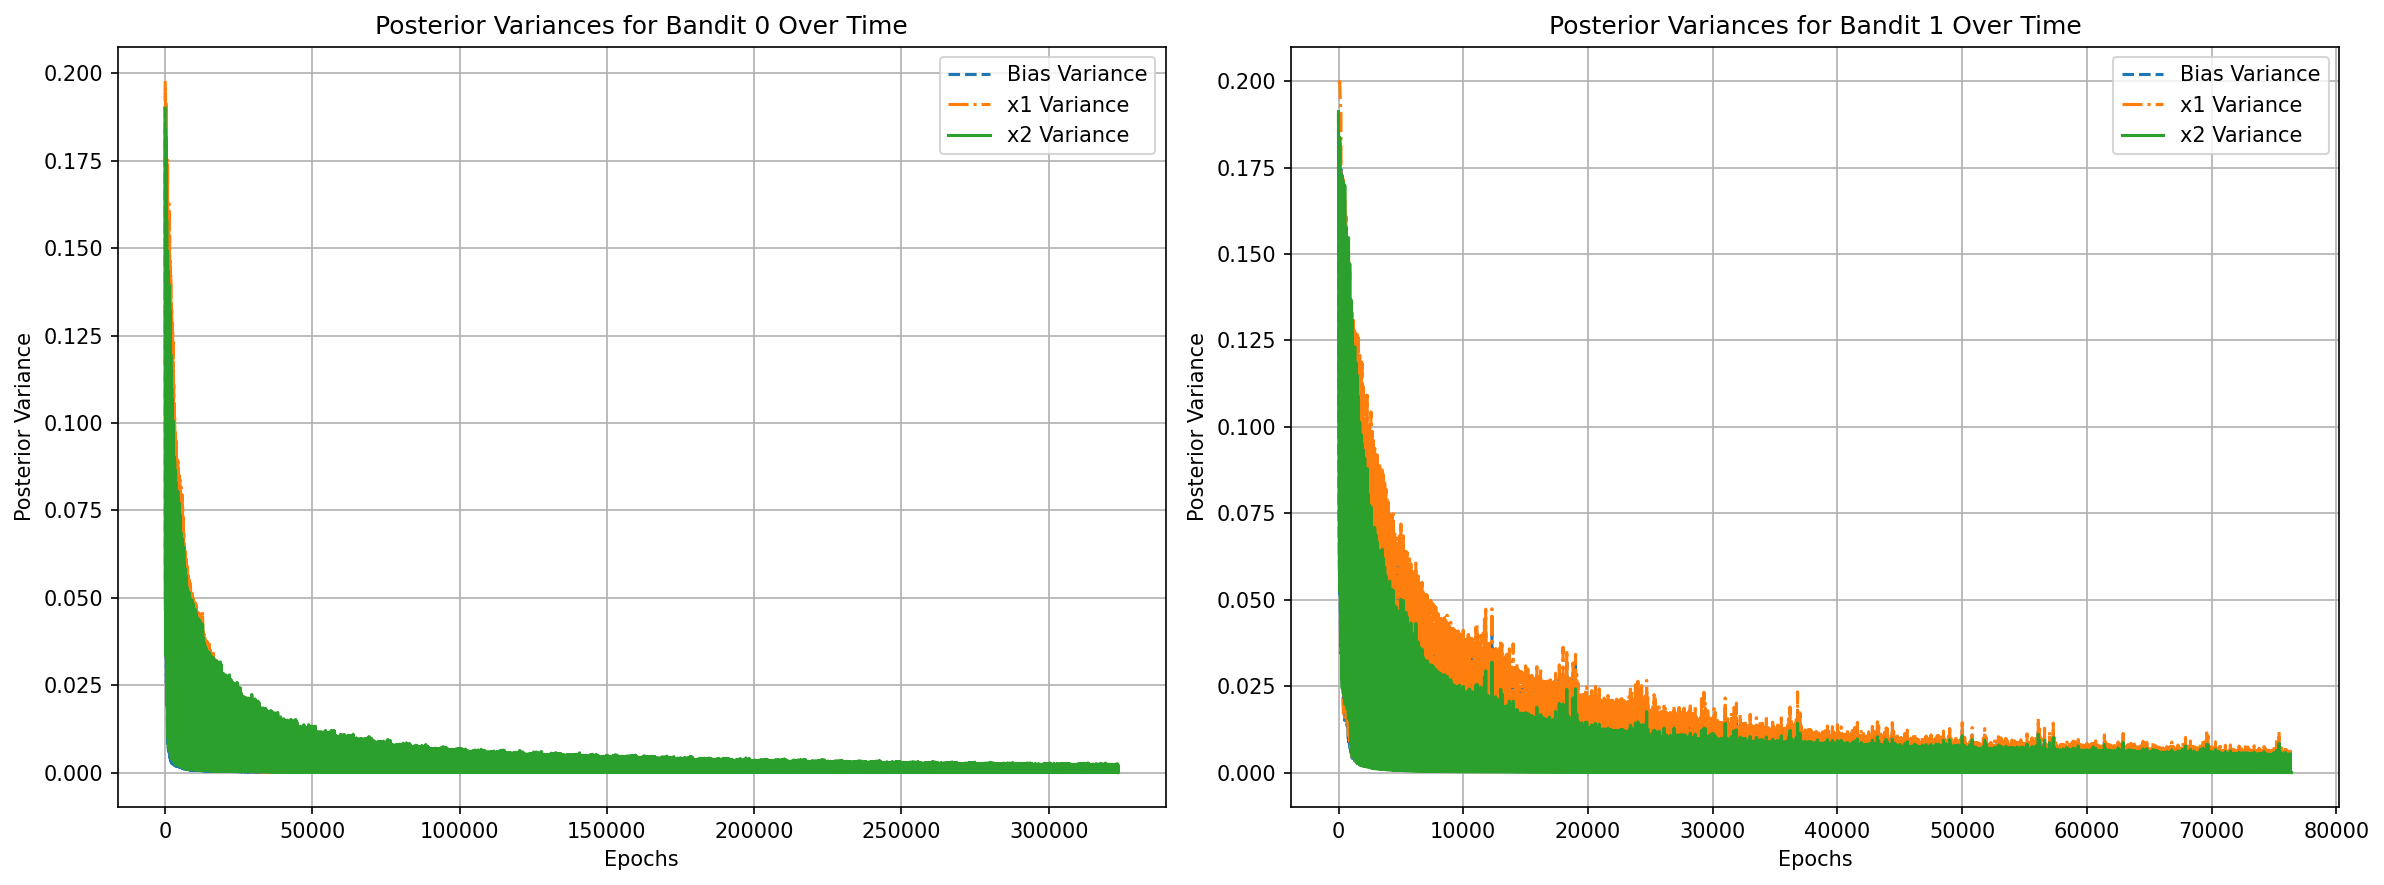

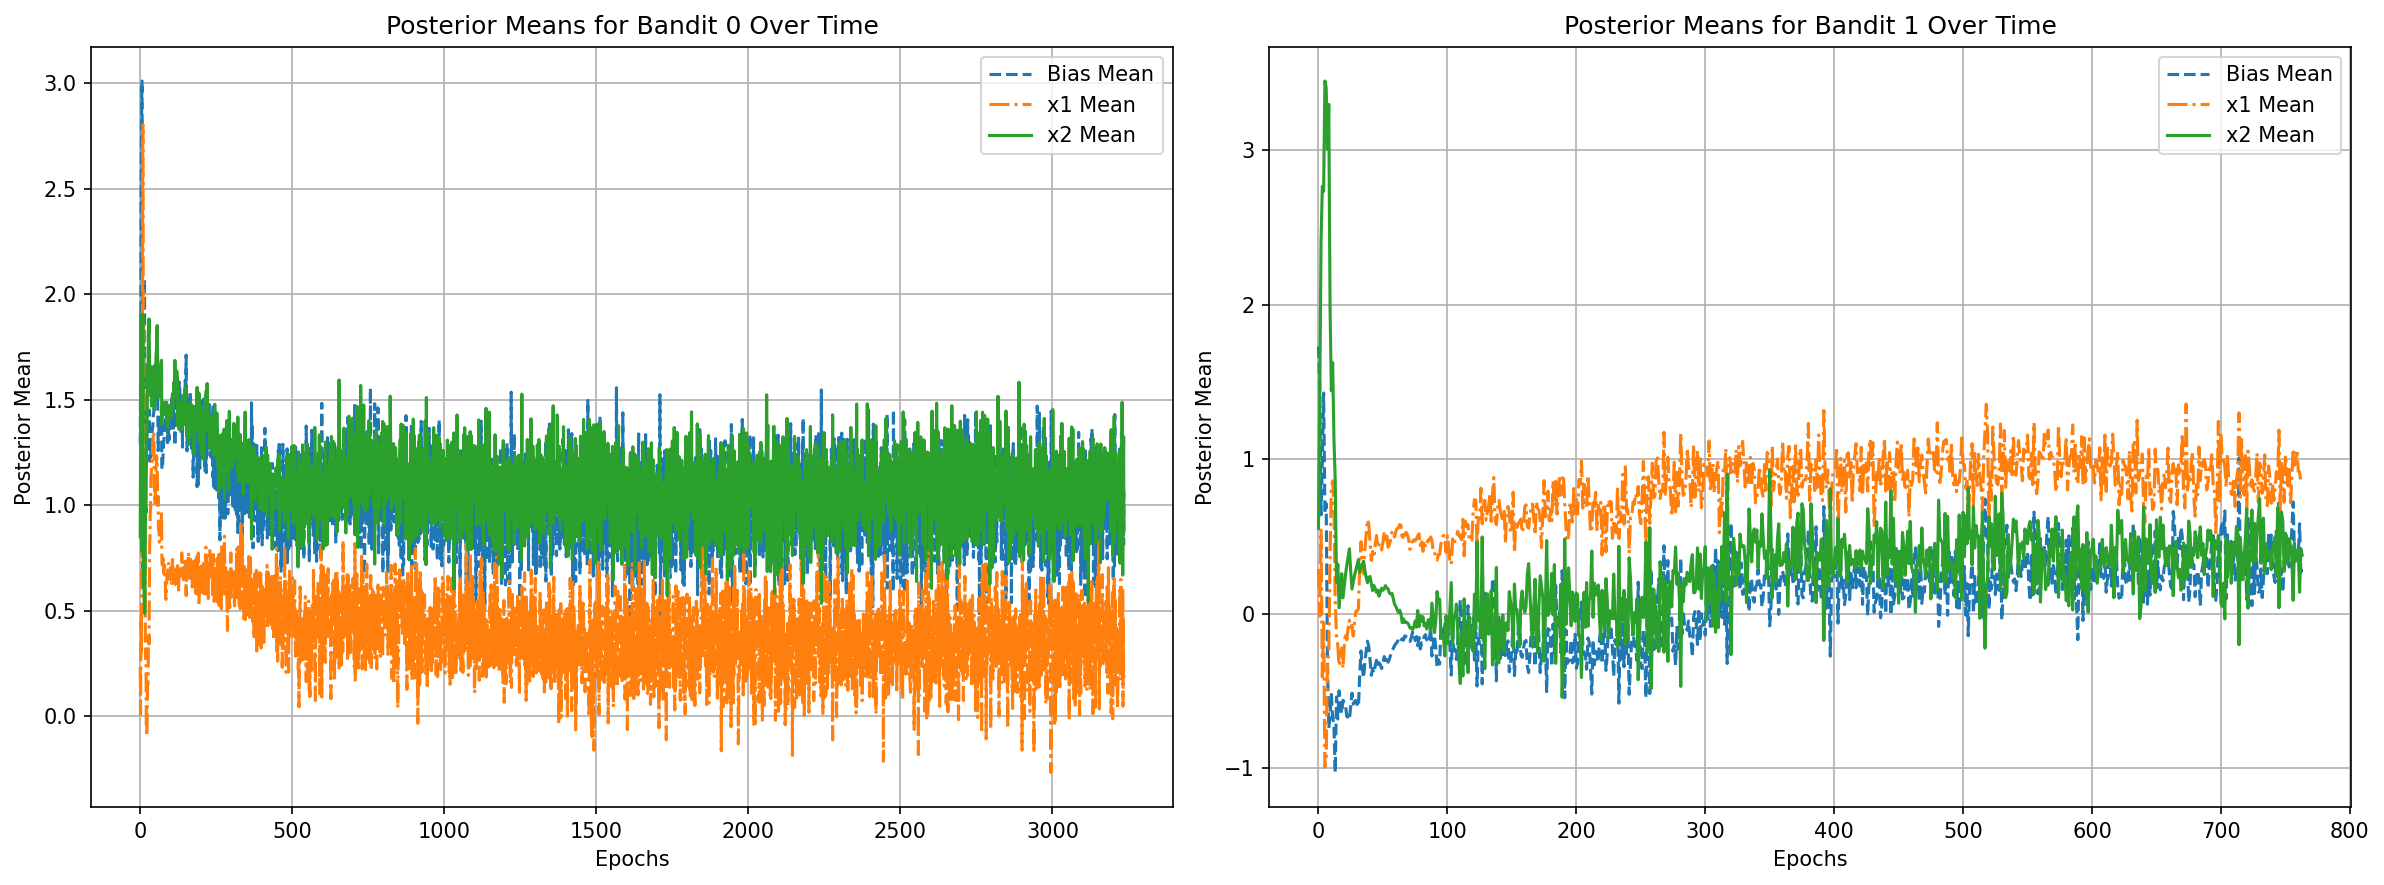

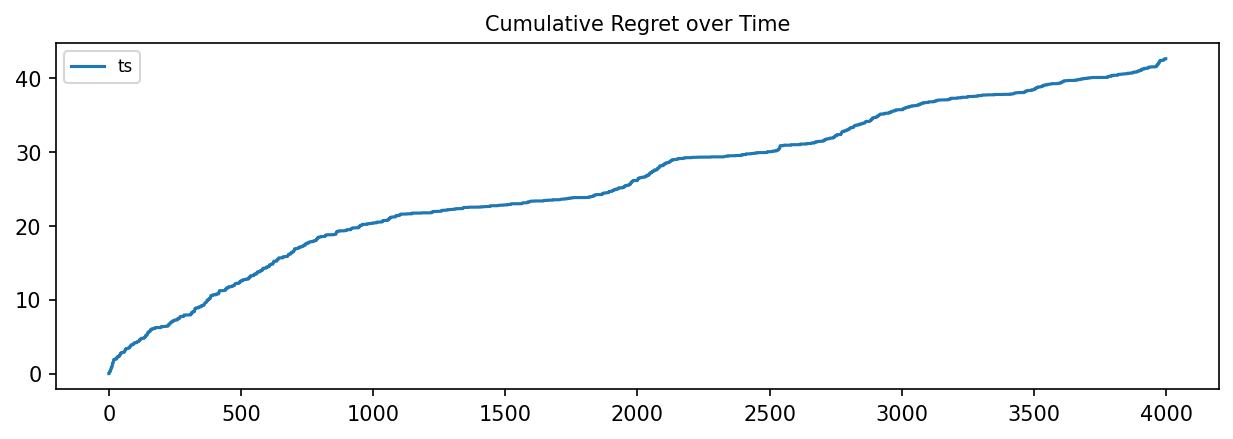

In [ ]:
class ThompsonSamplingSimulation:
    def __init__(self, n_rounds, n_bandits, lambda_, alpha, buffer_size=200):
        self.n_rounds = n_rounds
        self.n_bandits = n_bandits
        self.lambda_ = lambda_
        self.alpha = alpha
        self.buffer_size = buffer_size
        self.experiment_df = pd.DataFrame()
        self.results_dict = {
            'ts': {
                'k_array': np.zeros((n_bandits, n_rounds)),
                'reward_array': np.zeros((n_bandits, n_rounds)),
                'regret_array': np.zeros((1, n_rounds))[0]
            }
        }
        self.mean_log = {k: [] for k in range(self.n_bandits)}  # Initialize mean log to track posterior means for each bandit

    def run_simulation(self):
        ts_policy = ThompsonSamplingPolicy(lambda_=self.lambda_, alpha=self.alpha, n_bandits=self.n_bandits, buffer_size=self.buffer_size)
        dp_dict = {'ts': ts_policy.choose_bandit}

        for key, decision_policy in dp_dict.items():
            round_df = pd.DataFrame({'k': [], 'x1': [], 'x2': [], 'reward': []})
            variance_log = {k: [] for k in range(self.n_bandits)}  # Track variance per bandit

            for round_id in tqdm(range(self.n_rounds), desc="Simulation 1"):
                np.random.seed(self.n_rounds + round_id)
                # Generate two context values
                x1 = np.random.uniform(-1.5, 1.5, 1)[0]
                x2 = np.random.uniform(-1.5, 1.5, 1)[0]
                context = (x1, x2)

                # Choose a bandit based on the policy
                k = decision_policy(round_df, context)

                # Get reward, regret, and probability
                reward, regret, prob = bandit_env.draw(k, x1, x2)

                # Add this round's data to the round_df
                temp_df = pd.DataFrame({'x1': x1, 'x2': x2, 'k': k, 'reward': reward, 'regret': regret}, index=[round_id])
                round_df = pd.concat([round_df, temp_df])

                # Track variance if available
                ts_fit_output = ts_policy._fit_predict(round_df[round_df['k'] == k], context)
                variance_history = ts_fit_output['variance_history']
                self.mean_log[k].append(ts_fit_output['m'].iloc[0])  # Log the mean for the current bandit
                variance_log[k].extend(variance_history[0] if isinstance(variance_history, list) else variance_history)

            # Append round data to the experiment dataframe
            round_df = round_df.assign(simul_id=1, policy=key)
            self.experiment_df = pd.concat([self.experiment_df, round_df])

        self.experiment_df = self.experiment_df.reset_index(drop=True)



        # Visualize posterior variances for each bandit
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=150)
        for k, variances in variance_log.items():
            # Flatten the variances completely
            variances_flat = [var for sublist in variances for var in sublist] if any(isinstance(v, list) for v in variances) else variances

            # Separate the variances for bias, x1, and x2
            bias_variances = [v[0] for v in variances_flat]
            x1_variances = [v[1] for v in variances_flat]
            x2_variances = [v[2] for v in variances_flat]

            # Plot each parameter's variance for this bandit
            ax = axes[k]  # Select appropriate subplot
            ax.plot(bias_variances, label='Bias Variance', linestyle='--')
            ax.plot(x1_variances, label='x1 Variance', linestyle='-.')
            ax.plot(x2_variances, label='x2 Variance', linestyle='-')

            # Add titles and labels
            ax.set_title(f"Posterior Variances for Bandit {k} Over Time")
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Posterior Variance")
            ax.legend()
            ax.grid(True)

        plt.tight_layout()
        plt.show()

        # Visualize posterior means for each bandit
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=150)
        for k, means in self.mean_log.items():
            # Separate the means for bias, x1, and x2
            bias_means = [m[0] for m in means]
            x1_means = [m[1] for m in means]
            x2_means = [m[2] for m in means]

            # Plot each parameter's mean for this bandit
            ax = axes[k]  # Select appropriate subplot
            ax.plot(bias_means, label='Bias Mean', linestyle='--')
            ax.plot(x1_means, label='x1 Mean', linestyle='-.')
            ax.plot(x2_means, label='x2 Mean', linestyle='-')

            # Add titles and labels
            ax.set_title(f"Posterior Means for Bandit {k} Over Time")
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Posterior Mean")
            ax.legend()
            ax.grid(True)

        plt.tight_layout()
        plt.show()


    def plot_results(self):
        plt.close('all')
        plt.figure(figsize=(10, 3), dpi=150)

        cumulative_regret = self.experiment_df.reset_index().groupby(['policy', 'index'])['regret'].mean()

        for policy in ['ts']:
            plt.plot(np.cumsum(cumulative_regret.loc[policy, :].values), label=policy, linewidth=1.5)

        plt.title(f'Cumulative Regret over Time', fontsize=10)
        plt.legend(fontsize=8)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.show()


if __name__ == "__main__":
    n_rounds = 4000
    n_bandits = 2
    lambda_ = 5
    alpha = 1
    buffer_size = 400

    bandit_env = ContextualBanditEnvironment(n_bandits=2)

    simulation = ThompsonSamplingSimulation(n_rounds, n_bandits, lambda_, alpha, buffer_size)
    simulation.run_simulation()
    simulation.plot_results()

## **Observations**

**Posterior Mean and Variance Over Time**
* To validate the correctness of the implementation, I monitored the posterior variance and mean over time.
* The posterior variance reflects the model's uncertainty about the weights of the bias, x1, and x2.
  * A high variance at the start indicates the model is still uncertain about the true value of the weight.
  * The observed decline in variance indicates the model is gaining confidence in its estimate of the weight as more data points are observed.


While experimenting with lambda, buffer size, and learning rate, to achieve minimum cumulative regret over time, the following trends were observed:

1. **Buffer Size**:
* Increasing the buffer size from 200 to 400 resulted in faster convergence and reduced total cumulative regret (from 25 to 10).
* However, when the buffer size exceeded 400, performance began to degrade.


2. **Lambda(λ)**
- Decreasing λ: The posterior variance much reduced faster as expected.

- Increasing λ: Bandit 1's posterior variance was updated much less frequently, causing regret to take longer to converge.

3. **Learning Rate**:
- Increasing the learning rate from 0.01 to 0.05 significantly reduced total cumulative regret.
- Suprisingly, performance degraded when I introduced a decaying learning rate.

## Experiment: Varying alpha

Running simulation with alpha=0.25...


Simulation 1: 100%|██████████| 2000/2000 [00:51<00:00, 38.86it/s]


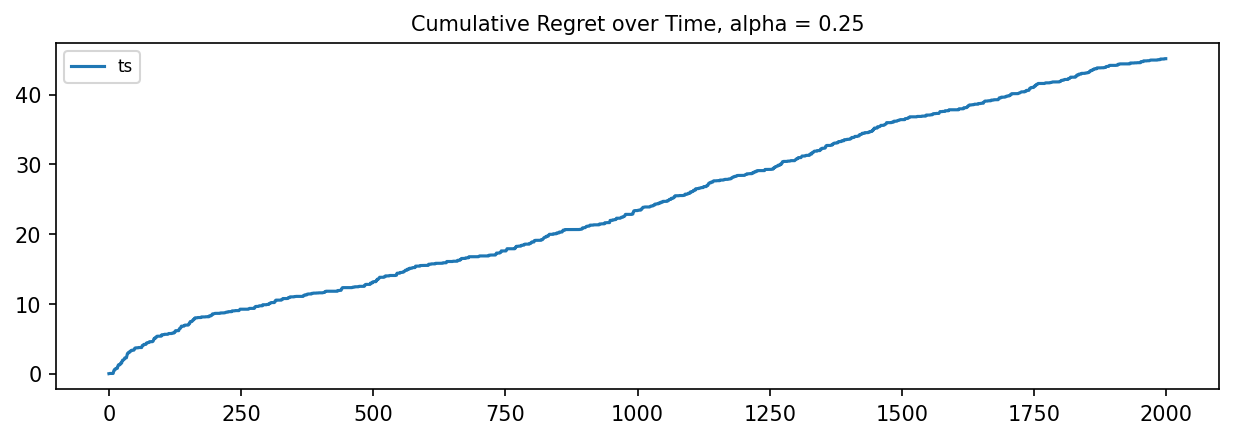

Running simulation with alpha=0.5...


Simulation 1: 100%|██████████| 2000/2000 [00:51<00:00, 38.83it/s]


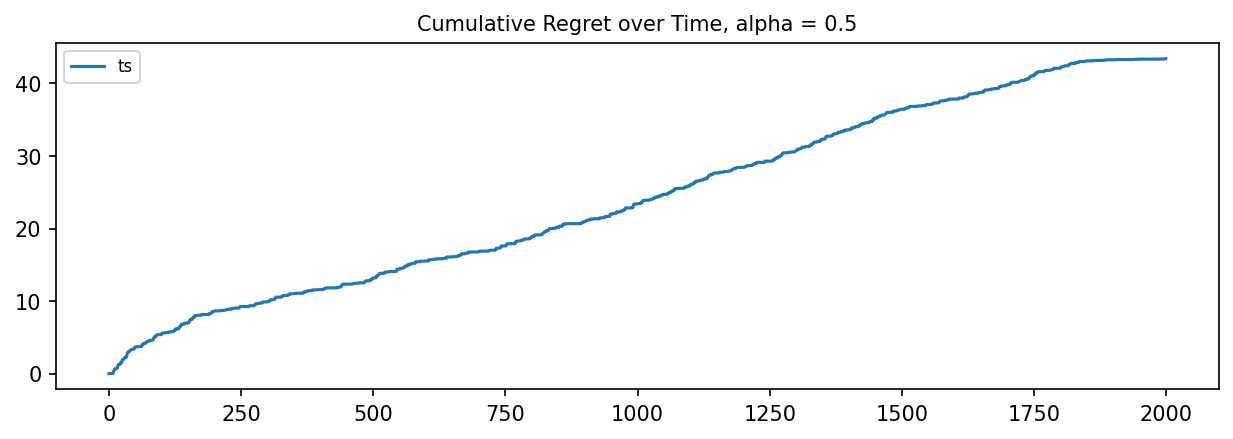

Running simulation with alpha=1...


Simulation 1: 100%|██████████| 2000/2000 [00:51<00:00, 38.75it/s]


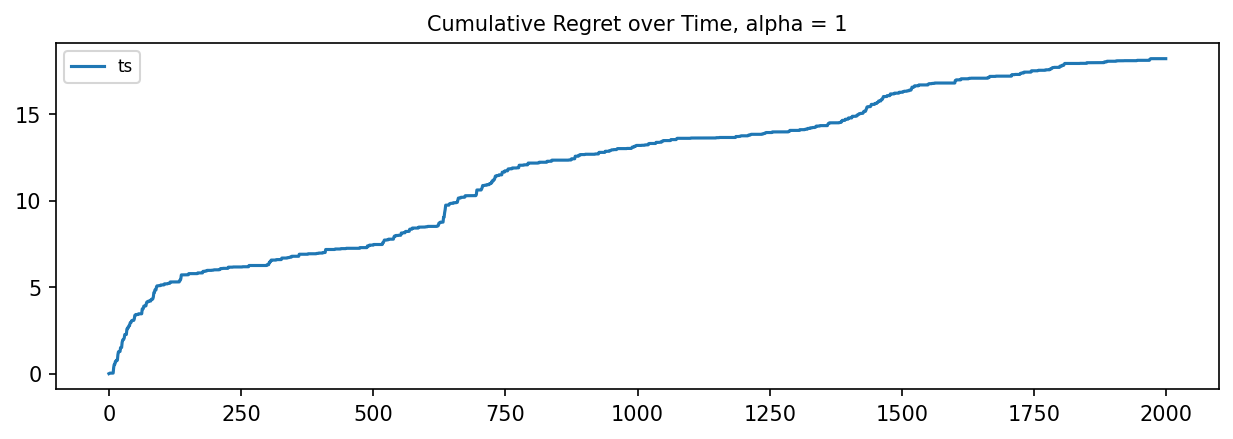

Running simulation with alpha=2.5...


Simulation 1: 100%|██████████| 2000/2000 [00:53<00:00, 37.24it/s]


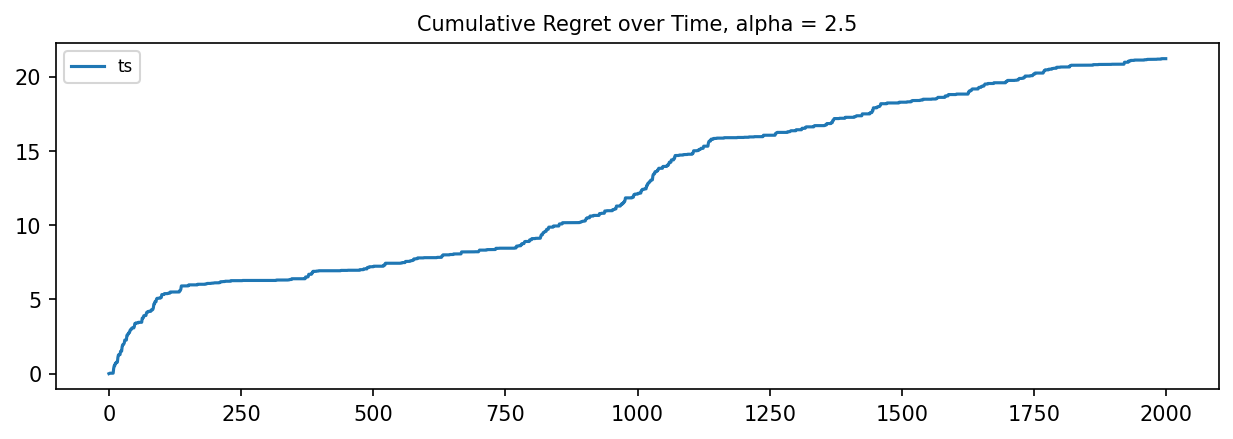

In [ ]:
class ThompsonSamplingSimulation:
    def __init__(self, n_rounds, n_bandits, lambda_, alpha, buffer_size=200):
        self.n_rounds = n_rounds
        self.n_bandits = n_bandits
        self.lambda_ = lambda_
        self.alpha = alpha
        self.buffer_size = buffer_size
        self.experiment_df = pd.DataFrame()
        self.results_dict = {
            'ts': {
                'k_array': np.zeros((n_bandits, n_rounds)),
                'reward_array': np.zeros((n_bandits, n_rounds)),
                'regret_array': np.zeros((1, n_rounds))[0]
            }
        }

    def run_simulation(self):
        ts_policy = ThompsonSamplingPolicy(lambda_=self.lambda_, alpha=self.alpha, n_bandits=self.n_bandits, buffer_size=self.buffer_size)
        dp_dict = {'ts': ts_policy.choose_bandit}

        for key, decision_policy in dp_dict.items():
            round_df = pd.DataFrame({'k': [], 'x1': [], 'x2': [], 'reward': []})
            variance_log = {k: [] for k in range(self.n_bandits)}  # Track variance per bandit

            for round_id in tqdm(range(self.n_rounds), desc="Simulation 1"):
                np.random.seed(self.n_rounds + round_id)
                # Generate two context values
                x1 = np.random.uniform(-1.5, 1.5, 1)[0]
                x2 = np.random.uniform(-1.5, 1.5, 1)[0]
                context = (x1, x2)

                # Choose a bandit based on the policy
                k = decision_policy(round_df, context)

                # Get reward, regret, and probability
                reward, regret, prob = bandit_env.draw(k, x1, x2)

                # Add this round's data to the round_df
                temp_df = pd.DataFrame({'x1': x1, 'x2': x2, 'k': k, 'reward': reward, 'regret': regret}, index=[round_id])
                round_df = pd.concat([round_df, temp_df])

            # Append round data to the experiment dataframe
            round_df = round_df.assign(simul_id=1, policy=key)
            self.experiment_df = pd.concat([self.experiment_df, round_df])

        self.experiment_df = self.experiment_df.reset_index(drop=True)

    def plot_results(self):
        plt.close('all')
        plt.figure(figsize=(10, 3), dpi=150)

        cumulative_regret = self.experiment_df.reset_index().groupby(['policy', 'index'])['regret'].mean()

        for policy in ['ts']:
            plt.plot(np.cumsum(cumulative_regret.loc[policy, :].values), label=policy, linewidth=1.5)

        plt.title(f'Cumulative Regret over Time, alpha = {alpha}', fontsize=10)
        plt.legend(fontsize=8)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.show()



if __name__ == "__main__":
    n_rounds = 2000
    n_bandits = 2
    lambda_ = 5
    buffer_size = 400

    for alpha in [0.25, 0.5,1, 2.5]:
        print(f"Running simulation with alpha={alpha}...")
        bandit_env = ContextualBanditEnvironment(n_bandits=n_bandits)
        simulation = ThompsonSamplingSimulation(n_rounds, n_bandits, lambda_, alpha, buffer_size)
        simulation.run_simulation()
        simulation.plot_results()

# Discussion
This project involved implementing the Thompson Sampling algorithm combined with Bayesian Regularized Logistic Regression, following the paper "An Empirical Evaluation of Thompson Sampling" by Chapelle et al..

Key findings include:
- The model's performance is highly sensitive to parameters such as λ, learning rate, and buffer size, emphasising the importance of hyperparameter tuning.
- Contrary to the paper's claims, setting α < 1 does increases exploitation however doesn't improve the models performance.


### **Future Work**
To avoid overcomplicating the code, this project used a simplified use case and left out other important validation metrics. However future work should include:

- **Lower Bound Asymptotic Curve**: Validate the algorithm's performance against theoretical lower bounds on regret, as discussed in the paper.
- **Model Comparisons**: Benchmark Thompson Sampling against other strategies, such as Upper Confidence Bound (UCB), epsilon-greedy, and exploit-only models.
- **Vary Number of Bandits**: Expand the implementation to handle a variable number of bandits, testing its robustness across different scenarios.
- **Real-World Data**: Replace uniform context generation with real-world datasets containing meaningful features to better simulate practical applications.


### **Practical Implementation Considerations**

1. Scalability: Larger buffer sizes and high-dimensional data can increase computational complexity. Efficient approximations or parallelism may be necessary.
2. Dynamic Contexts: Real-world contexts often evolve over time. Adapting the model to incorporate dynamic features could further improve performance.
3. Parameter Sensitivity: As demonstrated, hyperparameters like α, λ, and buffer size significantly impact the model's behavior. Careful tuning and validation are crucial.
